### 1. 데이터 준비와 확인

In [1]:
import pandas as pd
import tensorflow as tf
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from konlpy.tag import Mecab
import os
from gensim.models.keyedvectors import Word2VecKeyedVectors

In [2]:
# 데이터 읽기
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 2. 데이터로더 구성

In [3]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [4]:
index_to_word = {index: word for word, index in word_to_index.items()}

In [5]:
# 문장 1개와 활용할 딕셔너리를 주었을 때 단어 인덱스 리스트 벡터로 변환해줌. 모든 문장은 <BOS>로 시작.
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫제 벡터로 encode된 문장을 decode
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 숫자 벡터로 encode된 문장을 한꺼번에 decode
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3. 모델 구성을 위한 데이터 분석 및 가공

In [6]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이 리스트 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이, 최대길이, 표준편차
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))
# 최대길이 = 평균 + 2*표준편차
max_tokens = np.mean(num_tokens) + 2*np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [7]:
# padding 추가
X_train = keras.preprocessing.sequence.pad_sequences(X_train, padding='pre', 
                                                        maxlen=maxlen)
X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)
print(X_train.shape)

(146182, 41)


### 4. 모델 구성 및 validation set 구성

In [8]:
vocab_size = len(index_to_word)  # 어휘 사전의 크기
word_vector_dim = 300

#### (1) RNN

In [9]:
model1 = keras.Sequential()
model1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(keras.layers.LSTM(16))  
model1.add(keras.layers.Dense(8, activation='relu'))
model1.add(keras.layers.Dense(1, activation='sigmoid'))

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         3000000   
_________________________________________________________________
lstm (LSTM)                  (None, 16)                20288     
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 3,020,433
Trainable params: 3,020,433
Non-trainable params: 0
_________________________________________________________________


#### (2) 1-D CNN

In [10]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.MaxPooling1D(5))
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.GlobalMaxPooling1D())
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          33616     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

#### (3) GlobalMaxPooling1D

In [11]:
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(keras.layers.GlobalMaxPooling1D())
model3.add(keras.layers.Dense(8, activation='relu'))
model3.add(keras.layers.Dense(1, activation='sigmoid'))  

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 2408      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 3,002,417
Trainable params: 3,002,417
Non-trainable params: 0
_________________________________________________________________


#### validation set 구성하기

In [12]:
X_val = X_train[:29000]   
y_val = y_train[:29000]

# validation set을 제외한 나머지
partial_X_train = X_train[29000:]  
partial_y_train = y_train[29000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(117182, 41)
(117182,)


### 5. 모델 훈련 개시

#### (1) RNN

In [13]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history1 = model1.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

result = model1.evaluate(X_test,  y_test, verbose=2)

print(result)

Epoch 1/20
229/229 [==============================] - 5s 9ms/step - loss: 0.4257 - accuracy: 0.8111 - val_loss: 0.3436 - val_accuracy: 0.8521
Epoch 2/20
229/229 [==============================] - 2s 7ms/step - loss: 0.3161 - accuracy: 0.8669 - val_loss: 0.3323 - val_accuracy: 0.8561
Epoch 3/20
229/229 [==============================] - 2s 7ms/step - loss: 0.2784 - accuracy: 0.8834 - val_loss: 0.3335 - val_accuracy: 0.8569
Epoch 4/20
229/229 [==============================] - 2s 7ms/step - loss: 0.2453 - accuracy: 0.8985 - val_loss: 0.3393 - val_accuracy: 0.8572
Epoch 5/20
229/229 [==============================] - 2s 7ms/step - loss: 0.2171 - accuracy: 0.9118 - val_loss: 0.3566 - val_accuracy: 0.8558
Epoch 6/20
229/229 [==============================] - 2s 7ms/step - loss: 0.1919 - accuracy: 0.9229 - val_loss: 0.3879 - val_accuracy: 0.8516
Epoch 7/20
229/229 [==============================] - 2s 7ms/step - loss: 0.1709 - accuracy: 0.9332 - val_loss: 0.4232 - val_accuracy: 0.8528
Epoch 

#### (2) 1-D CNN

In [14]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history2 = model2.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

result = model2.evaluate(X_test,  y_test, verbose=2)

print("1-D CNN모델",result)

Epoch 1/20
229/229 [==============================] - 4s 10ms/step - loss: 0.4292 - accuracy: 0.7964 - val_loss: 0.3379 - val_accuracy: 0.8522
Epoch 2/20
229/229 [==============================] - 2s 8ms/step - loss: 0.2905 - accuracy: 0.8793 - val_loss: 0.3258 - val_accuracy: 0.8604
Epoch 3/20
229/229 [==============================] - 2s 8ms/step - loss: 0.2140 - accuracy: 0.9164 - val_loss: 0.3504 - val_accuracy: 0.8549
Epoch 4/20
229/229 [==============================] - 2s 8ms/step - loss: 0.1324 - accuracy: 0.9538 - val_loss: 0.4215 - val_accuracy: 0.8472
Epoch 5/20
229/229 [==============================] - 2s 8ms/step - loss: 0.0798 - accuracy: 0.9735 - val_loss: 0.4978 - val_accuracy: 0.8457
Epoch 6/20
229/229 [==============================] - 2s 8ms/step - loss: 0.0504 - accuracy: 0.9842 - val_loss: 0.5913 - val_accuracy: 0.8405
Epoch 7/20
229/229 [==============================] - 2s 8ms/step - loss: 0.0353 - accuracy: 0.9892 - val_loss: 0.6537 - val_accuracy: 0.8411
Epoch

#### (3) GlobalMaxPooling1D

In [15]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history3 = model3.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

result = model3.evaluate(X_test,  y_test, verbose=2)

print("GlobalMaxPooling1D()모델",result)

Epoch 1/20
229/229 [==============================] - 2s 6ms/step - loss: 0.4480 - accuracy: 0.8079 - val_loss: 0.3402 - val_accuracy: 0.8493
Epoch 2/20
229/229 [==============================] - 1s 5ms/step - loss: 0.3051 - accuracy: 0.8713 - val_loss: 0.3328 - val_accuracy: 0.8550
Epoch 3/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2556 - accuracy: 0.8969 - val_loss: 0.3415 - val_accuracy: 0.8557
Epoch 4/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2104 - accuracy: 0.9188 - val_loss: 0.3583 - val_accuracy: 0.8561
Epoch 5/20
229/229 [==============================] - 1s 5ms/step - loss: 0.1628 - accuracy: 0.9421 - val_loss: 0.3893 - val_accuracy: 0.8512
Epoch 6/20
229/229 [==============================] - 1s 5ms/step - loss: 0.1169 - accuracy: 0.9630 - val_loss: 0.4223 - val_accuracy: 0.8506
Epoch 7/20
229/229 [==============================] - 1s 5ms/step - loss: 0.0780 - accuracy: 0.9780 - val_loss: 0.4670 - val_accuracy: 0.8482
Epoch 

(1) RNN
loss: 0.8855 - accuracy: 0.8354

(2) 1-D CNN
loss: 1.1485 - accuracy: 0.8224

(3) GlobalMaxPoolinig1D
loss: 0.8243 - accuracy: 0.8389

#### GlobalMaxPooling1D 의 accuracy가 가장 높다.

### 6. Loss, Accuracy 그래프 시각화

#### (1) RNN

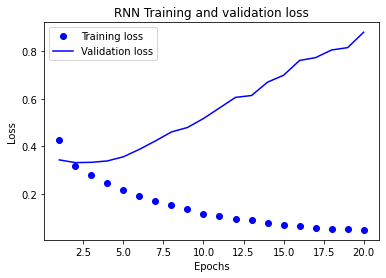

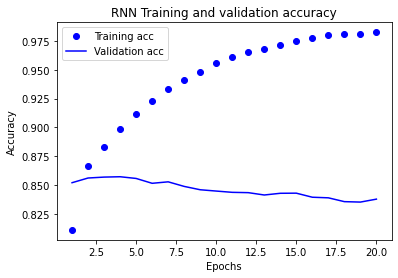

In [16]:
import matplotlib.pyplot as plt

history_dict1 = history1.history
acc = history_dict1['accuracy']
val_acc = history_dict1['val_accuracy']
loss = history_dict1['loss']
val_loss = history_dict1['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('RNN Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('RNN Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### (2) 1-D CNN

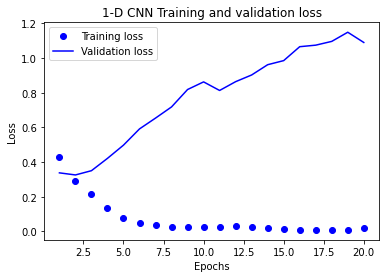

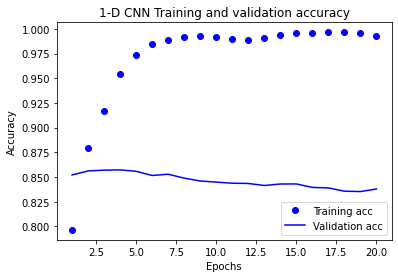

In [17]:
import matplotlib.pyplot as plt

history_dict2 = history2.history
acc = history_dict2['accuracy']
val_acc = history_dict1['val_accuracy']
loss = history_dict2['loss']
val_loss = history_dict2['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('1-D CNN Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('1-D CNN Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### (3)GlobalMaxPooling1D

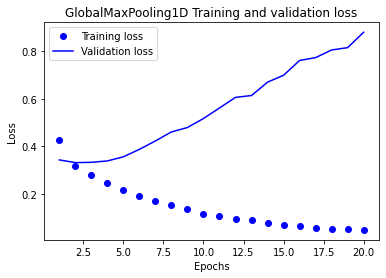

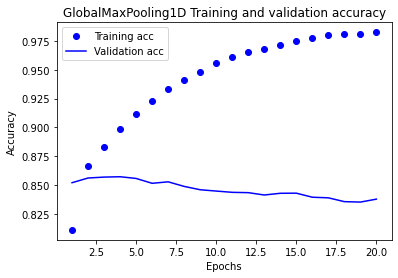

In [18]:
import matplotlib.pyplot as plt

history_dict3 = history1.history
acc = history_dict3['accuracy']
val_acc = history_dict3['val_accuracy']
loss = history_dict3['loss']
val_loss = history_dict1['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('GlobalMaxPooling1D Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('GlobalMaxPooling1D Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 7. 학습된 Embedding 레이어 분석

#### GlobalMaxPooling1D에 대해서 진행

In [19]:
embedding_layer = model3.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

# 학습한 Embedding 파라미터를 파일에 써서 저장함
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/GlobalMaxPooling1Dword2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록
vectors = model3.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
# '희망'이란 단어에 관한 유사도 결과
word_vectors.similar_by_word("희망")

(10000, 300)


[('소름', 0.35923391580581665),
 ('입니다', 0.34828412532806396),
 ('간지', 0.32339707016944885),
 ('공연', 0.3181781768798828),
 ('꿈', 0.31618058681488037),
 ('봤', 0.31129175424575806),
 ('굉장히', 0.3103622496128082),
 ('무조건', 0.30893954634666443),
 ('단어', 0.30806320905685425),
 ('강동원', 0.3049771785736084)]

유사하다고 보기 힘든 결과.

### 8. 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [20]:
from gensim.models import Word2Vec
kovec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
kovec = Word2Vec.load(kovec_file_path)
kovec.similar_by_word("희망")

/tmp/ipykernel_5620/1930576273.py:4: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  kovec.similar_by_word("희망")


[('열망', 0.571174144744873),
 ('행복', 0.5318456888198853),
 ('소망', 0.5299249887466431),
 ('염원', 0.5261855721473694),
 ('기쁨', 0.5192784070968628),
 ('갈망', 0.5077978372573853),
 ('기대', 0.49611741304397583),
 ('꿈', 0.49124279618263245),
 ('열정', 0.4850333631038666),
 ('약속', 0.48367926478385925)]

In [21]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피
for i in range(4,vocab_size):
    if index_to_word[i] in kovec:
        embedding_matrix[i] = kovec[index_to_word[i]]

/tmp/ipykernel_5620/3094502689.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in kovec:
/tmp/ipykernel_5620/3094502689.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = kovec[index_to_word[i]]


In [22]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 1608      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


In [24]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=60,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
1954/1954 [==============================] - 7s 4ms/step - loss: 0.3507 - accuracy: 0.8470 - val_loss: 0.4023 - val_accuracy: 0.8131
Epoch 2/10
1954/1954 [==============================] - 7s 3ms/step - loss: 0.3266 - accuracy: 0.8600 - val_loss: 0.3814 - val_accuracy: 0.8296
Epoch 3/10
1954/1954 [==============================] - 7s 3ms/step - loss: 0.3015 - accuracy: 0.8719 - val_loss: 0.3901 - val_accuracy: 0.8244
Epoch 4/10
1954/1954 [==============================] - 7s 3ms/step - loss: 0.2808 - accuracy: 0.8833 - val_loss: 0.3875 - val_accuracy: 0.8309
Epoch 5/10
1954/1954 [==============================] - 7s 3ms/step - loss: 0.2604 - accuracy: 0.8940 - val_loss: 0.4082 - val_accuracy: 0.8300
Epoch 6/10
1954/1954 [==============================] - 7s 3ms/step - loss: 0.2404 - accuracy: 0.9035 - val_loss: 0.4057 - val_accuracy: 0.8281
Epoch 7/10
1954/1954 [==============================] - 7s 3ms/step - loss: 0.2210 - accuracy: 0.9129 - val_loss: 0.4179 - val_accuracy:

In [25]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4854 - accuracy: 0.8256
[0.48542773723602295, 0.8255792856216431]


85% 실패!